<a href="https://colab.research.google.com/github/piers-hinds/sgd_noise/blob/main/notebooks/swgd_init.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+'https://github.com/piers-hinds/sgd_noise' &> /dev/null

In [2]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
from sgd_noise import *
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
n = 10
sigma = 0.10
true_theta = 0.9

torch.manual_seed(3)
noise = torch.randn(n) * sigma
xs = torch.linspace(0, 1, n)
ys = true_theta * xs + noise

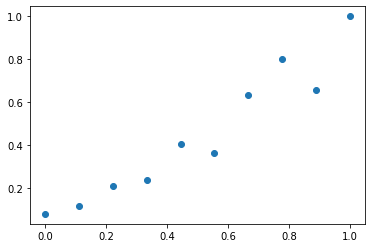

In [5]:
plt.scatter(xs, ys)

In [6]:
def model(theta, x):
    # 1d linear model
    return theta * x

def sq_err(x, y):
    return (x - y)**2

def wsq_err(x, y, w=None):
    # weighted square error
    if w is None:
        w = torch.ones_like(y)
    w = w / w.sum()
    return torch.sum(w * sq_err(x, y))